# Introduction to Fraud Detection Systems

In this tutorial, we are going to use the [credit card fraud detection dataset](https://www.kaggle.com/mlg-ulb/creditcardfraud) from Kaggle.

We are going to use the gradient boosting library [LightGBM](https://github.com/Microsoft/LightGBM), which has recently became one of the most popular libraries for top participants in [Kaggle competitions](https://github.com/Microsoft/LightGBM/tree/a39c848e6456d473d2043dff3f5159945a36b567/examples). 

To install the dependencies in Linux:
```bash
sudo apt-get update
sudo apt-get install cmake build-essential libboost-all-dev -y
conda env create -n fraud -f conda.yaml
source activate fraud
python -m ipykernel install --user --name fraud --display-name "Python (fraud)"
```

In [23]:
import numpy as np
import sys
import os
import json
import pandas as pd
from collections import Counter
import requests
from IPython.core.display import display, HTML
import lightgbm as lgb
import sklearn
import aiohttp
import asyncio
from utils import (split_train_test, classification_metrics_binary, classification_metrics_binary_prob,
                   binarize_prediction, plot_confusion_matrix, run_load_test)
from utils import BASELINE_MODEL, PORT

print("System version: {}".format(sys.version))
print("Numpy version: {}".format(np.__version__))
print("Pandas version: {}".format(pd.__version__))
print("LightGBM version: {}".format(lgb.__version__))
print("Sklearn version: {}".format(sklearn.__version__))

%load_ext autoreload
%autoreload 2

System version: 3.6.0 |Continuum Analytics, Inc.| (default, Dec 23 2016, 12:22:00) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
Numpy version: 1.13.3
Pandas version: 0.22.0
LightGBM version: 2.1.1
Sklearn version: 0.19.1
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

In [3]:
dataset_file = 'https://migonzastorage.blob.core.windows.net/datasets/fraud_detection/credit_card_fraud_kaggle/creditcard.csv'
df = pd.read_csv(dataset_file)

In [4]:
print("Shape: {}".format(df.shape))
df.head()

Shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [6]:
df['Class'].value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

In [7]:
X_train, X_test, y_train, y_test = split_train_test(df.drop('Class', axis=1), df['Class'], test_size=0.2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(227845, 30)
(56962, 30)
(227845,)
(56962,)


In [8]:
print(y_train.value_counts())
print(y_train.value_counts(normalize=True))
print(y_test.value_counts())
print(y_test.value_counts(normalize=True))

0    227451
1       394
Name: Class, dtype: int64
0    0.998271
1    0.001729
Name: Class, dtype: float64
0    56864
1       98
Name: Class, dtype: int64
0    0.99828
1    0.00172
Name: Class, dtype: float64


## Training with LightGBM - Baseline 

In [9]:
lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train, free_raw_data=False)

In [10]:
parameters = {'num_leaves': 2**8,
               'learning_rate': 0.1,
               'scale_pos_weight': 2,
               'min_split_gain': 0.1,
               'min_child_weight': 1,
               'reg_lambda': 1,
               'subsample': 1,
               'objective':'binary',
               'device': 'gpu',
               'task': 'train'
              }
num_rounds = 1000

In [11]:
%%time
clf = lgb.train(parameters, lgb_train, num_boost_round=num_rounds)

CPU times: user 2min 40s, sys: 7.28 s, total: 2min 47s
Wall time: 7.63 s


In [12]:
y_prob = clf.predict(X_test)
y_pred = binarize_prediction(y_prob)

In [13]:
metrics = classification_metrics_binary(y_test, y_pred)
metrics2 = classification_metrics_binary_prob(y_test, y_prob)
metrics.update(metrics2)
cm = metrics['Confusion Matrix']

{
    "AUC": 0.9779468448887716,
    "Accuracy": 0.9996137776061234,
    "F1": 0.8804347826086957,
    "Log loss": 0.0025394507247722773,
    "Precision": 0.9418604651162791,
    "Recall": 0.826530612244898
}


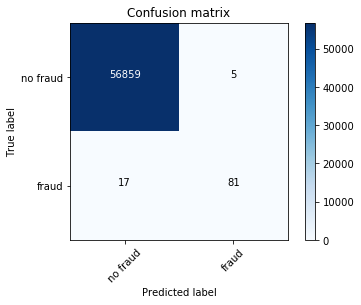

In [14]:
metrics.pop('Confusion Matrix', None)
print(json.dumps(metrics, indent=4, sort_keys=True))
plot_confusion_matrix(cm, ['no fraud', 'fraud'])

In [15]:
clf.save_model(BASELINE_MODEL)

## O16N with Flask and CherryPy

To start the api execute `python api.py` in the background

In [42]:
%%bash --bg --proc bg_proc
python api.py

In [43]:
#server_name = 'http://the-name-of-your-server'
server_name = 'http://localhost'
root_url = '{}:{}'.format(server_name, PORT)
res = requests.get(root_url)
display(HTML(res.text))

In [44]:
vals = y_test[y_test == 0].index.values
X_target = X_test.loc[vals[0]]
dict_query = X_target.to_dict()
print(dict_query)

{'Time': 160760.0, 'V1': -0.6744660645783139, 'V2': 1.40810501967799, 'V3': -1.11062205357093, 'V4': -1.32836577843066, 'V5': 1.3889960325483701, 'V6': -1.30843906707795, 'V7': 1.8858789026871698, 'V8': -0.614232966299775, 'V9': 0.31165221245310104, 'V10': 0.65075700363522, 'V11': -0.8577846615478051, 'V12': -0.229961445775592, 'V13': -0.19981700479102998, 'V14': 0.26637132632987903, 'V15': -0.0465441684754424, 'V16': -0.741398089749789, 'V17': -0.605616644106022, 'V18': -0.39256818789208003, 'V19': -0.162648311024695, 'V20': 0.394321820843914, 'V21': 0.0800842396026648, 'V22': 0.810033595602455, 'V23': -0.22432723043641198, 'V24': 0.7078992374468671, 'V25': -0.13583702273753, 'V26': 0.0451021964988772, 'V27': 0.533837219064273, 'V28': 0.291319252625364, 'Amount': 23.0}


In [46]:
headers = {'Content-type':'application/json'}
end_point = root_url + '/predict'
res = requests.post(end_point, data=json.dumps(dict_query), headers=headers)
print(res.ok)
print(json.dumps(res.json(), indent=2))


True
{
  "fraud": 6.756050441344813e-06
}


## Load test

In [47]:
num = 10
concurrent = 2
verbose = True
payload_list = [dict_query]*num

In [48]:
%%time
# Run:
with aiohttp.ClientSession() as session:  # We create a persistent connection
    loop = asyncio.get_event_loop()
    calc_routes = loop.run_until_complete(run_load_test(end_point, payload_list, session, concurrent, verbose))


ERROR:asyncio:Creating a client session outside of coroutine
client_session: <aiohttp.client.ClientSession object at 0x7f19de007588>


Response status: 200
{'fraud': 6.756050441344813e-06}
Response status: 200
Response status: 200
{'fraud': 6.756050441344813e-06}
{'fraud': 6.756050441344813e-06}
Response status: 200
Response status: 200
{'fraud': 6.756050441344813e-06}
{'fraud': 6.756050441344813e-06}
Response status: 200
Response status: 200
{'fraud': 6.756050441344813e-06}
{'fraud': 6.756050441344813e-06}
Response status: 200
{'fraud': 6.756050441344813e-06}
Response status: 200
{'fraud': 6.756050441344813e-06}
Response status: 200
{'fraud': 6.756050441344813e-06}
CPU times: user 30.5 ms, sys: 4.14 ms, total: 34.7 ms
Wall time: 362 ms


In [49]:
%%bash
ps aux | grep 'api.py' | grep -v 'grep' | awk '{print $2}' | xargs kill
#bg_proc.kill()